In [2]:
# This is needed to get AraBERT (transformers) and its backend (torch)
!pip install transformers torch


In [1]:
# Imports
import pandas as pd
import numpy as np
import re
import time
import nltk
from nltk.tokenize import word_tokenize
import joblib
import torch
from torch.utils.data import DataLoader, SequentialSampler, TensorDataset
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


In [16]:
# Preprocessing
ARABIC_DIACRITICS = re.compile(r'[\u064B-\u0652]')

def remove_diacritics(text):
    return ARABIC_DIACRITICS.sub('', text)

def remove_non_alpha(text):
    return re.sub(r'[^\w\s]', '', text)

def clean_text(text):
    if pd.isna(text) or not text:
        return ""
    text = str(text).lower()
    text = remove_diacritics(text)
    text = remove_non_alpha(text)
    return re.sub(r'\s+', ' ', text).strip()

def calculate_morph_complexity(tokens_col):
    if pd.isna(tokens_col) or not tokens_col:
        return 1.0
    original_words = tokens_col.split()
    total_morph_units = 0
    total_words = 0
    for word in original_words:
        morph_units = word.count('+') + 1
        total_morph_units += morph_units
        total_words += 1
    return total_morph_units / total_words if total_words > 0 else 1.0

# Data Loading and Cleaning
FILEPATH = 'bayyin_dataset.csv'
df = pd.read_csv(FILEPATH)
df.dropna(subset=['Sentence', 'Readability_Level'], inplace=True)
target_le = LabelEncoder()
df['Readability_Level_Encoded'] = target_le.fit_transform(df['Readability_Level'])
print(f"Readability Levels Mapped to: {dict(zip(target_le.classes_, target_le.transform(target_le.classes_)))}\n")

# AraBERT is trained on real text, so we'll just remove diacritics
df['Clean_Sentence_for_BERT'] = df['Sentence'].apply(lambda x: remove_diacritics(str(x)))



Readability Levels Mapped to: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(6): np.int64(5)}



In [18]:

# Statistical Feature Engineering
print("\n--- Starting Statistical Feature Engineering ---")
df['Word_Count'] = df['Word_Count'].astype(int)
df['Clean_Lex'] = df['Lex'].apply(clean_text)
df['Avg_Lex_Length'] = df['Clean_Lex'].apply(lambda x: np.mean([len(w) for w in x.split()]) if x else 0)
df['Lexical_Density'] = df['Clean_Lex'].apply(
    lambda x: len(set(x.split())) / len(x.split()) if len(x.split()) > 0 else 0
)
df['Morph_Complexity'] = df['D3Tok'].apply(calculate_morph_complexity)
print("Statistical features calculated.")

# statistical feature matrix
X_stats_numeric = df[['Word_Count', 'Avg_Lex_Length', 'Lexical_Density', 'Morph_Complexity']].values.astype(np.float64)




--- Starting Statistical Feature Engineering ---
Statistical features calculated.


In [11]:
df['Word_Count'].max()

182

In [31]:
# AraBERT Feature Extraction

print("\n--- Starting AraBERT Feature Extraction ---")

# use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# load AraBERT tokenizer and model
model_name = "aubmindlab/bert-base-arabertv02"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.to(device) # Move model to GPU
model.eval() # Set model to evaluation mode (disables dropout) --> maybe change later?

# tokenize all sentences
print("Tokenizing sentences...")
sentences = df['Clean_Sentence_for_BERT'].tolist()
print("Sentences number ", len(sentences))

# This tokenizes all sentences and prepares them for the model
tokenized_inputs = tokenizer(
    sentences,
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors="pt" # Return PyTorch tensors
)

# Create DataLoader for batch processing to make things faster
batch_size = 32
dataset = TensorDataset(tokenized_inputs['input_ids'], tokenized_inputs['attention_mask'])
sampler = SequentialSampler(dataset)
dataloader = DataLoader(dataset, sampler=sampler, batch_size=batch_size)

# Process in Batches
print(f"Extracting embeddings in batches of {batch_size}...")
all_embeddings = []

# Use torch.no_grad() to save memory and speed up
with torch.no_grad():
    for batch in tqdm(dataloader, desc="Embedding Sentences"):
        # Move batch tensors to the correct device
        batch_input_ids, batch_attention_mask = [b.to(device) for b in batch]

        # Get model outputs
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)

        # Get the [CLS] token embedding (the embedding for the entire sentence)
        # We take the embedding of the first token (index 0), which is [CLS]
        cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        all_embeddings.append(cls_embeddings)

# Combine all batch embeddings
X_arabert = np.vstack(all_embeddings)
print(f"AraBERT embedding matrix shape: {X_arabert.shape}") # Should be (46410, 768)



--- Starting AraBERT Feature Extraction ---
Using device: cuda
Tokenizing sentences...
Sentences number  46410
Extracting embeddings in batches of 32...


Embedding Sentences: 100%|██████████| 1451/1451 [11:42<00:00,  2.07it/s]


AraBERT embedding matrix shape: (46410, 768)


In [32]:

# Combine Features for Final Model
print("\n--- Combining Statistical and AraBERT Features ---")

# X_stats_numeric shape: (46410, 4)
# X_arabert shape: (46410, 768)

X_combined = np.hstack([X_stats_numeric, X_arabert])
y = df['Readability_Level_Encoded'].values

print(f"Final combined feature matrix shape: {X_combined.shape}")
print(f"Target vector shape: {y.shape}")



--- Combining Statistical and AraBERT Features ---
Final combined feature matrix shape: (46410, 772)
Target vector shape: (46410,)


In [33]:
# Split the new combined dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

Training set: (37128, 772), Test set: (9282, 772)


In [34]:
# Convert to DataFrame if they’re numpy arrays
X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)
y_train_df = pd.DataFrame(y_train, columns=['Readability_Level'])
y_test_df = pd.DataFrame(y_test, columns=['Readability_Level'])

# Save to CSV
X_train_df.to_csv("X_train.csv", index=False)
X_test_df.to_csv("X_test.csv", index=False)
y_train_df.to_csv("y_train.csv", index=False)
y_test_df.to_csv("y_test.csv", index=False)

In [35]:
joblib.dump((X_train, X_test, y_train, y_test), "train_test_split.pkl")

print("✅ Train/test split saved to 'train_test_split.pkl'")
#X_train, X_test, y_train, y_test = joblib.load("train_test_split.pkl")

✅ Train/test split saved to 'train_test_split.pkl'


In [36]:

# Train Random Forest on Combined Features

rf_model = RandomForestClassifier(
    n_estimators=100,  # Good baseline
    max_depth=30,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

start_time = time.time()
rf_model.fit(X_train, y_train)
print(f"Model training finished in {time.time() - start_time:.2f} seconds.")


Model training finished in 263.49 seconds.


In [37]:

# Final Evaluation
print("\n--- Final Model Evaluation ---")
y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nFINAL ACCURACY: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=[str(c) for c in target_le.classes_], digits=3))



--- Final Model Evaluation ---

FINAL ACCURACY: 0.5324

Classification Report:
              precision    recall  f1-score   support

           1      0.582     0.725     0.646      1547
           2      0.492     0.539     0.514      1547
           3      0.398     0.334     0.363      1547
           4      0.396     0.268     0.319      1547
           5      0.526     0.582     0.552      1547
           6      0.721     0.747     0.734      1547

    accuracy                          0.532      9282
   macro avg      0.519     0.532     0.521      9282
weighted avg      0.519     0.532     0.521      9282



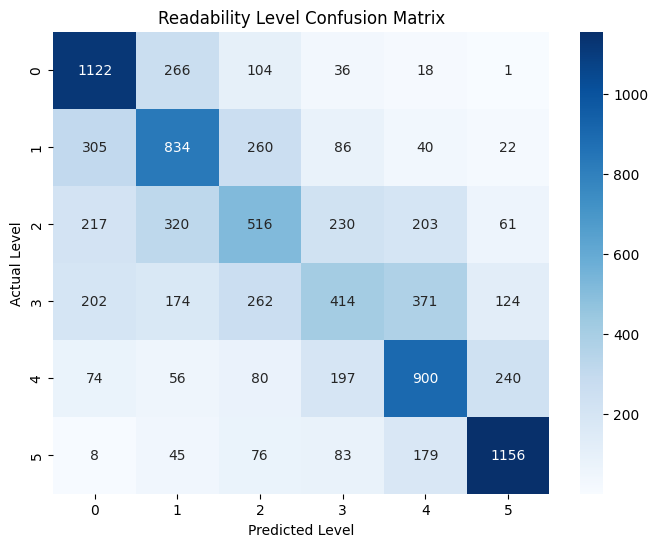

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Level")
plt.ylabel("Actual Level")
plt.title("Readability Level Confusion Matrix")
plt.show()

In [39]:

#  Feature Importance
print("\n--- Top Feature Importances ---")

# Create feature names for the combined matrix
stats_features = ['Word_Count', 'Avg_Lex_Length', 'Lexical_Density', 'Morph_Complexity']
arabert_features = [f'BERT_{i}' for i in range(X_arabert.shape[1])]
all_feature_names = stats_features + arabert_features

importances = rf_model.feature_importances_

importance_df = pd.Series(importances, index=all_feature_names).sort_values(ascending=False)

print("Top 20 most important features:")
print(importance_df.head(20))

print("\nImportance of Statistical Features:")
print(importance_df.loc[stats_features])



--- Top Feature Importances ---
Top 20 most important features:
Word_Count         0.015598
BERT_47            0.007893
BERT_142           0.005649
BERT_257           0.005456
Lexical_Density    0.005456
BERT_294           0.005261
BERT_290           0.004770
BERT_598           0.004707
BERT_444           0.004643
BERT_485           0.003911
BERT_279           0.003698
BERT_92            0.003524
BERT_424           0.003493
BERT_494           0.003475
BERT_14            0.003053
BERT_373           0.003046
BERT_602           0.003042
BERT_23            0.003033
BERT_306           0.002969
BERT_296           0.002898
dtype: float64

Importance of Statistical Features:
Word_Count          0.015598
Avg_Lex_Length      0.002257
Lexical_Density     0.005456
Morph_Complexity    0.001461
dtype: float64
